gan_folder/plot_C49/comp_1.png
gan_folder/plot_C49/comp_2.png
gan_folder/plot_C49/comp_3.png
gan_folder/plot_C49/comp_4.png
gan_folder/plot_C49/comp_5.png


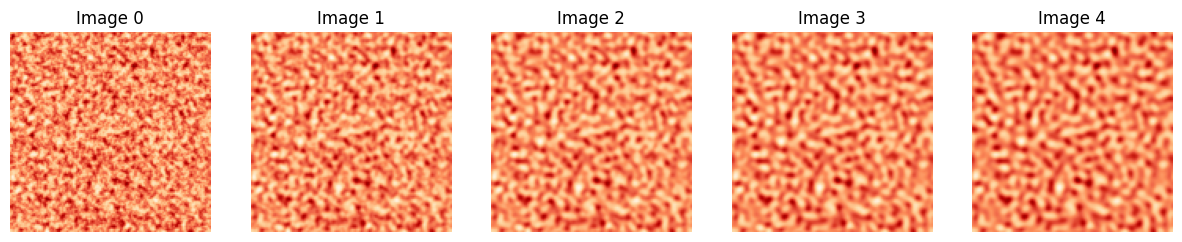

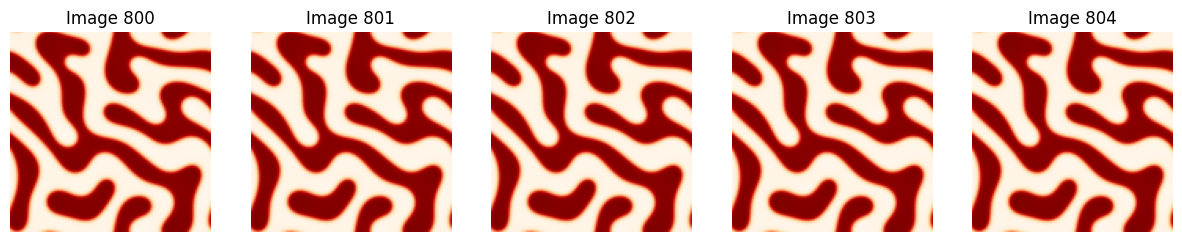

In [1]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Unzipping the dataset
shutil.unpack_archive('/content/microstructures.zip', 'gan_folder')  # Unzipping the dataset into the folder 'gan_folder'

# Loading and preprocessing images
dir = "gan_folder/plot_C49/*.png"
path = os.path.join(dir)
data = glob.glob(path)

# Sorting the images based on the numerical order in the filenames
data.sort(key=lambda x: int(os.path.basename(x).split('.')[0][5:]))

# Loading and preprocessing the images
def preprocess_images(data):
    images = []
    for fname in data:
        img = Image.open(fname).resize((128, 128))  # Resize the images to 128x128 dimensions
        img = np.array(img)
        if img.shape[2] == 4:  # If image has 4 channels (e.g., RGBA), convert to 3 channels (e.g., RGB)
            img = img[:, :, :3]  # Discard the alpha channel
        img = img.astype('float32') / 255.0  # Normalize the images
        images.append(img)
    return np.array(images)

# Printing the first 5 image paths
for item in data[:5]:
    print(item)

def visualize_first_images(data):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, fname in enumerate(data[:5]):
        img = Image.open(fname)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i}")
        axes[i].axis("off")
    plt.show()

# Visualizing the first 5 images
visualize_first_images(data)

def visualize_images(data):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, fname in enumerate(data[800:805]):
        img = Image.open(fname)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+800}")
        axes[i].axis("off")
    plt.show()

# Visualizing images from 800-805
visualize_images(data)

# Preprocessing the data
train_set = preprocess_images(data[:900])
test_set = preprocess_images(data[900:])


In [2]:

#  Defining the generator model
def build_generator():
    model = keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(128 * 16 * 16, activation="relu"),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding="same", activation="sigmoid")  # Change to 3 channels
    ])
    return model

# Defining the discriminator model
def build_discriminator():
    model = keras.Sequential([
        layers.Input(shape=(128, 128, 3)),  # Change to 3 channels
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Building GAN
generator = build_generator()
discriminator = build_discriminator()

# Freezing discriminator weights for GAN
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)

gan = keras.Model(gan_input, gan_output)
gan.compile(optimizer="adam", loss="binary_crossentropy")

In [3]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       3475043   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 265409    
                                                                 
Total params: 3740452 (14.27 MB)
Trainable params: 3475043 (13.26 MB)
Non-trainable params: 265409 (1.01 MB)
_________________________________________________________________


In [5]:

def train_gan(generator, discriminator, gan, real_images, epochs=8000, batch_size=64):
    half_batch = batch_size // 2
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))

    for epoch in range(epochs):
        # Training discriminator with real images
        idx = np.random.randint(0, real_images.shape[0], half_batch)
        real_batch = real_images[idx]

        d_loss_real = discriminator.train_on_batch(real_batch, real_labels)

        # Training discriminator with fake images
        noise = np.random.randn(half_batch, 100)
        fake_images = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Training generator
        noise = np.random.randn(batch_size, 100)
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            print(f"Epoch {epoch} D Loss Real: {d_loss_real[0]} D Loss Fake: {d_loss_fake[0]} G Loss: {g_loss}")
        if epoch == 7999:
            print(f"Epoch {epoch} D Loss Real: {d_loss_real[0]} D Loss Fake: {d_loss_fake[0]} G Loss: {g_loss}")
    return generator, discriminator

gan_model, discriminator_model = train_gan(generator, discriminator, gan, train_set, epochs=8000, batch_size=64)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
Epoch 4000 D Loss Real: 0.002853392856195569 D Loss Fake: 0.14223727583885193 G Loss: 2.816192626953125
1/1 [==============================] - 0s 16ms/step
Epoch 5000 D Loss Real: 0.3400349020957947 D Loss Fake: 0.06601561605930328 G Loss: 4.191280364990234
1/1 [==============================] - 0s 28ms/step
Epoch 6000 D Loss Real: 0.2462618350982666 D Loss Fake: 0.01118658110499382 G Loss: 4.666577339172363
1/1 [==============================] - 0s 26ms/step
Epoch 7000 D Loss Real: 0.008558204397559166 D Loss Fake: 0.022169198840856552 G Loss: 5.230279922485352
1/1 [==============================] - 0s 17ms/step
Epoch 7999 D Loss Real: 0.01925012096762657 D Loss Fake: 0.03977472335100174 G Loss: 3.927194833755493


1/1 [==============================] - 0s 275ms/step


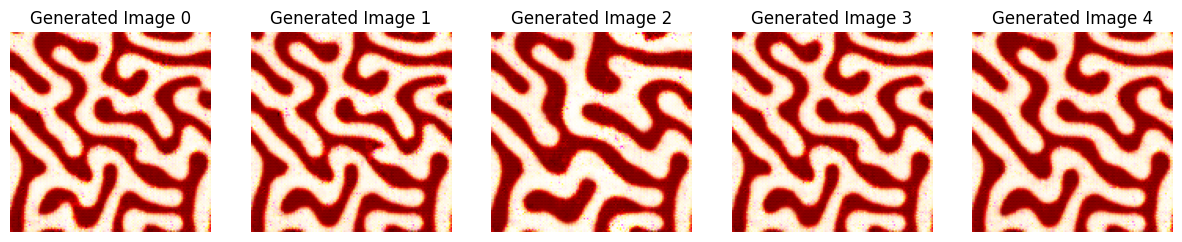

1/1 [==============================] - 0s 175ms/step


In [6]:
# Generating and visualizing images
noise = np.random.randn(5, 100)
generated_images = generator.predict(noise)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    generated_image = generated_images[i]  # Get the ith generated image
    axes[i].imshow(generated_image)
    axes[i].set_title(f"Generated Image {i}")
    axes[i].axis("off")
plt.show()

In [9]:
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

# Function to preprocess and compute InceptionV3 features for a set of images
def compute_inception_features(images):
    # Load InceptionV3 model pretrained on ImageNet without the top layer
    inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize and preprocess images
    images_resized = []
    for img in images:
        img = image.array_to_img(img, scale=False)
        img = img.resize((299, 299))
        img = image.img_to_array(img)
        images_resized.append(img)

    images_preprocessed = preprocess_input(np.array(images_resized))

    # Get feature representations
    features = inception.predict(images_preprocessed)

    return features

# Function to compute FID between real and generated images
def calculate_fid(real_images, generated_images):
    # Compute Inception features for real and generated images
    real_features = compute_inception_features(real_images)
    generated_features = compute_inception_features(generated_images)

    # Calculating mean and covariance statistics
    mu_real = np.mean(real_features, axis=0)
    mu_generated = np.mean(generated_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_generated = np.cov(generated_features, rowvar=False)

    # Computing FID score
    eps = 1e-6
    cov_sqrt = sqrtm(sigma_real.dot(sigma_generated) + eps * np.eye(sigma_real.shape[0]))
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    fid = np.sum((mu_real - mu_generated)**2) + np.trace(sigma_real + sigma_generated - 2 * cov_sqrt)

    return fid

# Example usage within your existing code
# Assuming you have `gan_model` and `test_set` defined and trained as in your previous code snippets

# Generating some images using the trained generator
num_samples = 100  # Number of generated images to evaluate
noise = np.random.randn(num_samples, 100)
generated_images = generator.predict(noise)

# Ensure test_set is in the correct range [0, 1]
test_set = test_set[:num_samples]

# Calculate FID between test_set (real images) and generated_images
fid_score = calculate_fid(test_set, generated_images)
print(f"FID Score: {fid_score}")


4/4 [==============================] - 2s 117ms/step
FID Score: 14.853472793818717
